In [26]:
import pandas as pd
import os

# === Step 1: Load and clean merged data ===

# Adjusted path: go up one level from notebooks/ to access data/interim
df = pd.read_csv("../data/interim/merged_data.csv")

# Filter to only include years up to 2022
df = df[df["Year"] <= 2022]

# Sort by Country and Year (most recent first) for proper fill
df = df.sort_values(by=["Country", "Year"], ascending=[True, False])

# Fill missing values using most recent data available (backward then forward fill)
df_cleaned = (
    df.groupby("Country", group_keys=False)
      .apply(lambda g: g.bfill().ffill(), include_groups=False)
      .reset_index(drop=True)
)

In [27]:
# --- (1) normalize your four raw indicators as you already have ---
def normalize(s):
    return (s - s.min()) / (s.max() - s.min())

df_norm = df_cleaned.copy()
df_norm["life_expectancy_norm"]    = normalize(df_norm["Life_Expectancy"])
df_norm["infant_mortality_norm"]  = 1 - normalize(df_norm["Mortality_Rate"])
df_norm["average_schooling_norm"] = normalize(df_norm["average_schooling"])
df_norm["learning_outcome_norm"]  = normalize(df_norm["learning_scores"])

# --- (2) build raw sub-indices by averaging their two pieces ---
df_norm["health_index_raw"]      = df_norm[["life_expectancy_norm", "infant_mortality_norm"]].mean(axis=1)
df_norm["education_index_raw"]  = df_norm[["average_schooling_norm", "learning_outcome_norm"]].mean(axis=1)

# --- (3) rescale each so its country‐mean = 1 ---
df_norm["health_index"]      = df_norm["health_index_raw"]     / df_norm["health_index_raw"].mean()
df_norm["education_index"]  = df_norm["education_index_raw"]   / df_norm["education_index_raw"].mean()

# --- (4) combine into a final performance index (equal weight) ---
df_norm["HEP"] = df_norm[["health_index","education_index"]].mean(axis=1)

# (because both sub-indices now average to 1, performance_index will too)

# Normalize Health and Education Expenditure so that their mean = 1
df_norm["Health_Expenditure_norm"] = (
    df_norm["Health_Expenditure"] / df_norm["Health_Expenditure"].mean()
)
df_norm["Education_Expenditure_norm"] = (
    df_norm["Education_Expenditure"] / df_norm["Education_Expenditure"].mean()
)

# build efficiency sub-indices
df_norm["health_eff_index"] = (
    df_norm["health_index"] / df_norm["Health_Expenditure_norm"]
)
df_norm["education_eff_index"] = (
    df_norm["education_index"] / df_norm["Education_Expenditure_norm"]
)

# combine into a final efficiency index (equal weight) ---
df_norm["HEE"] = df_norm[["health_eff_index","education_eff_index"]].mean(axis=1)

In [28]:
result = df_norm[["ISO3", "Year", "income_level", "HEP", "HEE"]].copy()
# === Step 4: Save only HEP & HEE results ===
result = df_norm[["ISO3", "Year", "income_level", "HEP", "HEE"]].copy()


In [29]:
print("✅ HEP & HEE calculated and saved successfully.")
print(result.tail())


✅ HEP & HEE calculated and saved successfully.
     ISO3  Year         income_level       HEP       HEE
1260  VNM  2004  Lower middle income  1.031994  1.231556
1261  VNM  2003  Lower middle income  1.024156  1.253471
1262  VNM  2002  Lower middle income  1.013597  1.256908
1263  VNM  2001  Lower middle income  1.002204  1.086351
1264  VNM  2000  Lower middle income  0.989390  1.182313


In [30]:
result.to_csv("../data/interim/cek.csv", index=False)

In [31]:
import pandas as pd
import os

# === Auto-install pycountry if missing ===
try:
    import pycountry
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pycountry"])
    import pycountry

# === Step 1: Load the data ===
data_path = "../data/interim/cek.csv"
df = pd.read_csv(data_path)

# === Step 2: Define compact country-to-region mapping ===
emea = [
    "ARM", "CYP", "CZE", "EGY", "ETH", "DEU", "GRC", "IRL", "JOR", "KAZ", "KEN", "KGZ", "FRA",
    "LBN", "MAR", "NLD", "NGA", "ROU", "SRB", "SVK", "TJK", "TUN", "TUR", "UKR", "GBR", "UZB", "RUS", "IRN"
]
apac = [
    "AUS", "BGD", "CHN", "IND", "IDN", "JPN", "MYS", "MNG", "MMR",
    "NZL", "PAK", "PHL", "SGP", "THA", "VNM", "KOR"
]
latam = [
    "ARG", "BRA", "CHL", "ECU", "GTM", "MEX", "NIC", "PER", "URY"
]
na = ["CAN", "USA"]

# Combine into a single dictionary
country_region_map = {
    **{ISO3: "EMEA" for ISO3 in emea},
    **{ISO3: "APAC" for ISO3 in apac},
    **{ISO3: "LATAM" for ISO3 in latam},
    **{ISO3: "NA" for ISO3 in na},
}

# === Step 3: Map region and country name ===
df["Region"] = df["ISO3"].map(country_region_map)

def get_country_name(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).name
    except:
        return "Unknown"

df["Country"] = df["ISO3"].apply(get_country_name)

# === Step 4: Warn unmapped ISO3 codes ===
unmapped = df[df["Region"].isnull()]["ISO3"].unique()
if len(unmapped) > 0:
    print("⚠️ Warning: The following countries couldn't be mapped to a region:")
    for c in unmapped:
        print(f"- {c}")
    print("👉 Please update 'country_region_map' with these countries.")

# === Step 5: Save updated file ===
output_path = "../data/interim/cek.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"✅ 'Region' and 'Country' columns added and saved to: {output_path}")

✅ 'Region' and 'Country' columns added and saved to: ../data/interim/cek.csv


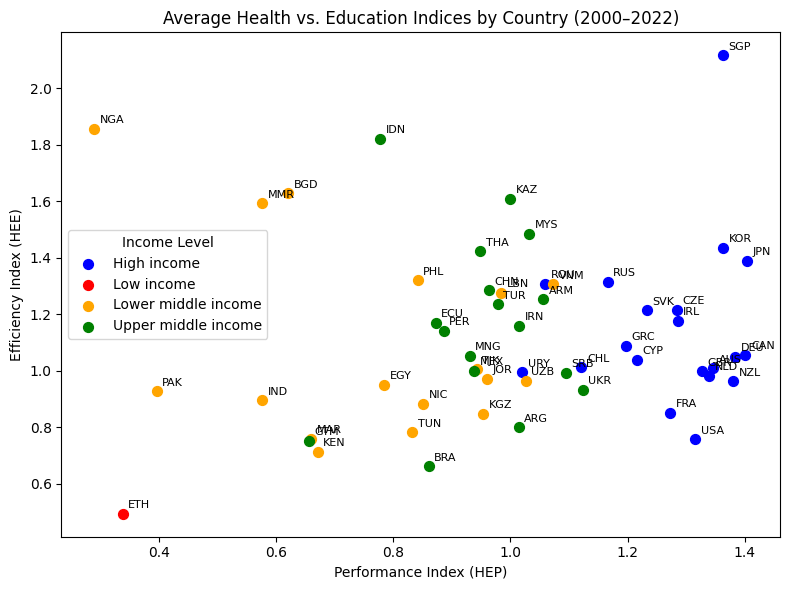

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your data
df = pd.read_csv("../data/interim/cek.csv")

# 2. Filter for the period 2000–2022 (if needed)
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2022)]

# 3. Compute each country’s average HEE & HEP, preserving the ISO3 and income level
avg_df = (
    df
    .groupby(['ISO3', 'income_level'], as_index=False)
    .agg({'HEE': 'mean', 'HEP': 'mean'})
)

# 4. Map income groups to colors
color_map = {
    'High income': 'blue',
    'Upper middle income': 'green',
    'Lower middle income': 'orange',
    'Low income': 'red'
}
avg_df['color'] = avg_df['income_level'].map(color_map)

# 5. Plot with ISO3 annotations
fig, ax = plt.subplots(figsize=(8,6))
for level, grp in avg_df.groupby('income_level'):
    ax.scatter(grp['HEP'], grp['HEE'], label=level, color=color_map[level], s=50)

# Annotate each point with its ISO3 code
for _, row in avg_df.iterrows():
    ax.annotate(
        row['ISO3'],
        (row['HEP'], row['HEE']),
        xytext=(4, 4),
        textcoords='offset points',
        fontsize=8
    )

ax.set_xlabel('Performance Index (HEP)')
ax.set_ylabel('Efficiency Index (HEE)')
ax.set_title('Average Health vs. Education Indices by Country (2000–2022)')
ax.legend(title='Income Level')
plt.tight_layout()
plt.show()
